In [ ]:
words = open("names.txt", 'r').read().splitlines()

# E01

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

## Trigram counting

In [ ]:
import torch
N = torch.zeros((27, 27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

P = (N+1).float()
P /= P.sum(2, keepdim=True)

In [ ]:
# Loss function
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1, ix2, ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob: .4f} {logprob: .4f}')

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


In [ ]:
# Sampling
g = torch.Generator().manual_seed(2148483647)

for i in range(10):
    ix1, ix2 = 0, 0
    out = []
    while True:
        p = P[ix1, ix2]
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1 = ix2
        ix2 = ix3
    print(''.join(out))

feon.
se.
rademi.
wynnakoldesmar.
bryn.
volennison.
ah.
orah.
aamellen.
uviky.


## Neural Net

In [ ]:
import torch.nn.functional as F

In [ ]:
# create the training set of trigrams
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([54, 27], generator=g, requires_grad=True)

In [ ]:
for i in range(500):
    # forward pass
    X1_one_hot = F.one_hot(xs[:, 0], num_classes=27).float()
    X2_one_hot = F.one_hot(xs[:, 1], num_classes=27).float()
    xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(probs)), ys].log().mean() + 0.01 * (W**2).mean()
    if i % 100 == 0:
        print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50 * W.grad

4.1959710121154785
2.272444725036621
2.2593140602111816
2.2556772232055664
2.254220485687256


In [ ]:
# Sampling
g = torch.Generator().manual_seed(2148483647)

for i in range(10):
    ix1, ix2 = 0, 0
    out = []
    while True:
        X1_one_hot = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        X2_one_hot = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1 = ix2
        ix2 = ix3
    print(''.join(out))

uen.
are.
rademin.
sonaa.
adesmar.
bely.
am.
nnelioniaha.
rahia.
xellen.


# E02

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import random
random.shuffle(words)
num_dev = int(0.1 * len(words))
dev, test, train = words[:num_dev], words[num_dev:num_dev*2], words[num_dev*2:]

In [ ]:
def create_bigram_data(data):
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            xs.append(ix1)
            ys.append(ix2)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

def create_trigram_data(data):
    xs, ys = [], []
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            xs.append([ix1, ix2])
            ys.append(ix3)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [ ]:
bigram_xs_train, bigram_ys_train = create_bigram_data(train)
bigram_xs_dev, bigram_ys_dev = create_bigram_data(dev)
bigram_xs_test, bigram_ys_test = create_bigram_data(test)

trigram_xs_train, trigram_ys_train = create_trigram_data(train)
trigram_xs_dev, trigram_ys_dev = create_trigram_data(dev)
trigram_xs_test, trigram_ys_test = create_trigram_data(test)

In [ ]:
# evaluate function
def eval(xs, ys, w, bigram=True):
    if bigram == False:
        X1_one_hot = F.one_hot(trigram_xs_train[:, 0], num_classes=27).float()
        X2_one_hot = F.one_hot(trigram_xs_train[:, 1], num_classes=27).float()
        xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)
    else:
        xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    return loss.item()

it 0
train loss: 3.767681121826172
dev loss: 3.7657289505004883
test loss: 3.759673595428467
--------------------------------------------------
it 100
train loss: 2.4902074337005615
dev loss: 2.476829767227173
test loss: 2.4713003635406494
--------------------------------------------------
it 200
train loss: 2.483206272125244
dev loss: 2.467632293701172
test loss: 2.4623889923095703
--------------------------------------------------
it 300
train loss: 2.48173451423645
dev loss: 2.4652323722839355
test loss: 2.4600653648376465
--------------------------------------------------
it 400
train loss: 2.4812123775482178
dev loss: 2.4642269611358643
test loss: 2.4590978622436523
--------------------------------------------------


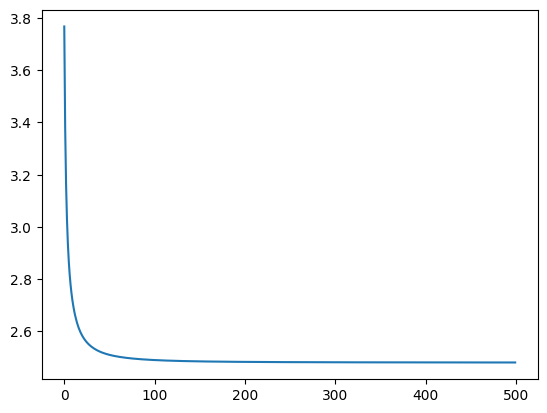

In [ ]:
# Bigram training
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([27, 27], generator=g, requires_grad=True)
# gradient descent
losses = []
for i in range(500):

    # forward pass
    xenc = F.one_hot(bigram_xs_train, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(probs)), bigram_ys_train].log().mean() + 0.01 * (W**2).mean()
    losses.append(loss.item())
    if i % 100 == 0:
        print(f'it {i}')
        print('train loss:', loss.item())
        print('dev loss:', eval(bigram_xs_dev, bigram_ys_dev, W))
        print('test loss:', eval(bigram_xs_test, bigram_ys_test, W))
        print('-'*50)

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

plt.plot(losses)

it 0
train loss: 4.194879531860352
dev loss: 4.124340534210205
test loss: 4.116871356964111
--------------------------------------------------
it 100
train loss: 2.2715044021606445
dev loss: 3.3498432636260986
test loss: 3.3359780311584473
--------------------------------------------------
it 200
train loss: 2.258418321609497
dev loss: 3.392117500305176
test loss: 3.380305528640747
--------------------------------------------------
it 300
train loss: 2.2548084259033203
dev loss: 3.4102187156677246
test loss: 3.399571418762207
--------------------------------------------------
it 400
train loss: 2.2533695697784424
dev loss: 3.4198553562164307
test loss: 3.409881591796875
--------------------------------------------------


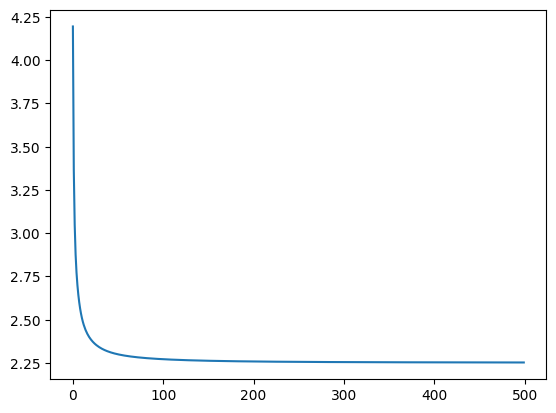

In [ ]:
# Trigram training
# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([54, 27], generator=g, requires_grad=True)
# gradient descent
losses = []
for i in range(500):
    # forward pass
    X1_one_hot = F.one_hot(trigram_xs_train[:, 0], num_classes=27).float()
    X2_one_hot = F.one_hot(trigram_xs_train[:, 1], num_classes=27).float()
    xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(probs)), trigram_ys_train].log().mean() + 0.01 * (W**2).mean()
    losses.append(loss.item())
    if i % 100 == 0:
        print(f'it {i}')
        print('train loss:', loss.item())
        print('dev loss:', eval(trigram_xs_dev, trigram_ys_dev, W, bigram=False))
        print('test loss:', eval(trigram_xs_test, trigram_ys_test, W, bigram=False))
        print('-'*50)

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

plt.plot(losses)

While the trigram model achieved a marginally lower training loss compared to the bigram model, the bigram exhibits superior generalization performance as evidenced by its stability on the development and test sets.  We observed an increase in both development and test loss for the trigram model after it 200, indicating potential overfitting.

# E03

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [ ]:
possible_regs = [1, 0.5, 0.1, 0.01, 0.001, 0]
all_train_losses = []
all_dev_losses = []
models = []
# Trigram training

# gradient descent

for reg in possible_regs:
    losses = []
    dev_losses = []
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn([54, 27], generator=g, requires_grad=True)
    print(f"Regularization: {reg}")
    print("="*50)
    for i in range(500):
        # forward pass
        X1_one_hot = F.one_hot(trigram_xs_train[:, 0], num_classes=27).float()
        X2_one_hot = F.one_hot(trigram_xs_train[:, 1], num_classes=27).float()
        xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(len(probs)), trigram_ys_train].log().mean() + reg * (W**2).mean()
        losses.append(loss.item())
        dev_loss = eval(trigram_xs_dev, trigram_ys_dev, W, bigram=False)
        dev_losses.append(dev_loss)
        if i % 100 == 0:
            print(f'it {i}')
            print('train loss:', loss.item())
            print('dev loss:', dev_loss)
            print('test loss:', eval(trigram_xs_test, trigram_ys_test, W, bigram=False))
            print('-'*50)

        # backward pass
        W.grad = None # set to zero the gradient
        loss.backward()

        # update
        W.data += -50 * W.grad
    all_train_losses.append(losses)
    all_dev_losses.append(dev_losses)
    models.append(W)



Regularization: 1
it 0
train loss: 5.155220031738281
dev loss: 4.124340534210205
test loss: 4.116871356964111
--------------------------------------------------
it 100
train loss: 2.544710397720337
dev loss: 3.0485751628875732
test loss: 3.0417184829711914
--------------------------------------------------
it 200
train loss: 2.544710159301758
dev loss: 3.0485711097717285
test loss: 3.0417144298553467
--------------------------------------------------
it 300
train loss: 2.544710159301758
dev loss: 3.0485711097717285
test loss: 3.0417144298553467
--------------------------------------------------
it 400
train loss: 2.544710159301758
dev loss: 3.0485711097717285
test loss: 3.0417144298553467
--------------------------------------------------
Regularization: 0.5
it 0
train loss: 4.670199871063232
dev loss: 4.124340534210205
test loss: 4.116871356964111
--------------------------------------------------
it 100
train loss: 2.4515392780303955
dev loss: 3.1046340465545654
test loss: 3.09639954

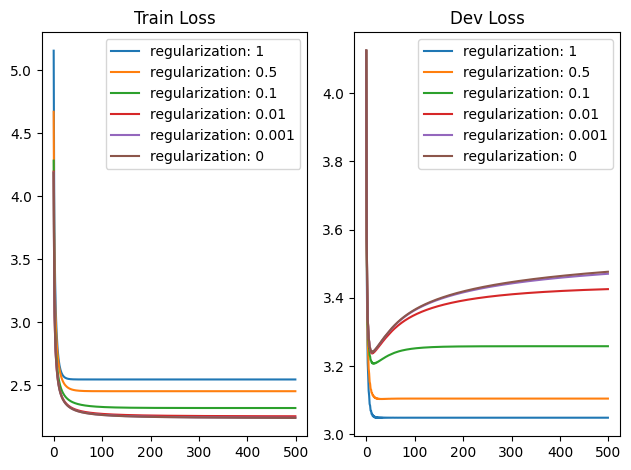

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for i, reg in enumerate(possible_regs):
    ax1.plot(all_train_losses[i], label=f"regularization: {reg}")
    ax2.plot(all_dev_losses[i], label=f"regularization: {reg}")
    ax1.legend()
    ax1.set_title('Train Loss')
    ax2.legend()
    ax2.set_title('Dev Loss')
plt.tight_layout()

plt.show()

In [ ]:
for i in range(len(models)):
    print(eval(trigram_xs_test, trigram_ys_test, models[i], bigram=False))

3.0417144298553467
3.096412181854248
3.24794340133667
3.4159419536590576
3.461522102355957
3.467561721801758


Regularization 1 appears to perform the best based on the current evaluation.

# E04

We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [78]:
# Trigram training

# gradient descent

losses = []
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([54, 27], generator=g, requires_grad=True)

for i in range(500):
    # forward pass
    # X1_one_hot = F.one_hot(trigram_xs_train[:, 0], num_classes=27).float()
    # X2_one_hot = F.one_hot(trigram_xs_train[:, 1], num_classes=27).float()
    # xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)

    # logits = xenc @ W

    # simply indexing into rows of W
    x1 = xs[:, 0]
    x2 = xs[:, 1]
    x1_w = W[x1] # The first 27 rows (0-26) are intended for the first input (X1).
    x2_w = W[x2 + 27] # The next 27 rows (27-53) are intended for the second input (X2).
    logits = torch.cat([x1_w, x2_w], dim=1)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(probs)), ys].log().mean() + reg * (W**2).mean()
    losses.append(loss.item())
    if i % 100 == 0:
        print(f'it {i}')
        print('train loss:', loss.item())
        print('-'*50)

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

it 0
train loss: 4.452778339385986
--------------------------------------------------
it 100
train loss: 2.6013174057006836
--------------------------------------------------
it 200
train loss: 2.5734376907348633
--------------------------------------------------
it 300
train loss: 2.563947916030884
--------------------------------------------------
it 400
train loss: 2.5592777729034424
--------------------------------------------------


# E05

Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [79]:
# Trigram training

# gradient descent

losses = []
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([54, 27], generator=g, requires_grad=True)

for i in range(500):
    # forward pass
    # X1_one_hot = F.one_hot(trigram_xs_train[:, 0], num_classes=27).float()
    # X2_one_hot = F.one_hot(trigram_xs_train[:, 1], num_classes=27).float()
    # xenc = torch.cat([X1_one_hot, X2_one_hot], dim=1)

    # logits = xenc @ W

    # simply indexing into rows of W
    x1 = xs[:, 0]
    x2 = xs[:, 1]
    x1_w = W[x1] # The first 27 rows (0-26) are intended for the first input (X1).
    x2_w = W[x2 + 27] # The next 27 rows (27-53) are intended for the second input (X2).
    logits = torch.cat([x1_w, x2_w], dim=1)
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # loss = -probs[torch.arange(len(probs)), ys].log().mean() + reg * (W**2).mean()

    # new, using F.cross_entropy to calculate loss
    loss = F.cross_entropy(logits, ys)
    losses.append(loss.item())
    if i % 100 == 0:
        print(f'it {i}')
        print('train loss:', loss.item())
        print('-'*50)

    # backward pass

    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

it 0
train loss: 4.452778339385986
--------------------------------------------------
it 100
train loss: 2.6013171672821045
--------------------------------------------------
it 200
train loss: 2.5734376907348633
--------------------------------------------------
it 300
train loss: 2.563947916030884
--------------------------------------------------
it 400
train loss: 2.5592780113220215
--------------------------------------------------


We prefer to use F.cross_entropy because it handles both the softmax activation and the computation of the cross-entropy loss in a single, numerically stable step. This combined approach not only simplifies the code but also prevents common numerical issues associated with manual calculations of softmax probabilities, such as underflow or overflow. Additionally, integrating these operations can lead to more efficient gradient computations during model training.